In [6]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import io
import requests
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [7]:
# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from sklearn.metrics import roc_auc_score
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn

In [8]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

#from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from torchmetrics.functional import auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [9]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [14]:
df = pd.read_csv('../rcsed.csv')

In [16]:
gasmet = pd.read_csv('../rcsed_gasmet.csv')

In [17]:
id_col = ['objid','specobjid']
z_col = [  'exp_tau','exp_met','z', 'e_bv', 'ssp_age', 'ssp_met', 'specclass']

band_col = [
    'corrmag_fuv', 'corrmag_nuv', 'corrmag_u', 'corrmag_g', 'corrmag_r', 'corrmag_i', 
    'corrmag_z', 'corrmag_y', 'corrmag_j', 'corrmag_h', 'corrmag_k'
]

kcorr_col = [
     'kcorr_fuv','kcorr_nuv','kcorr_u','kcorr_g','kcorr_r','kcorr_i',
     'kcorr_z','kcorr_y','kcorr_j','kcorr_h','kcorr_k',
]

In [18]:
col = id_col + z_col + band_col + kcorr_col

In [19]:
data = df[col].dropna()

In [20]:
data[band_col].head()

,corrmag_fuv,corrmag_nuv,corrmag_u,corrmag_g,corrmag_r,corrmag_i,corrmag_z,corrmag_y,corrmag_j,corrmag_h,corrmag_k
18,20.430805,20.963827,19.483593,18.175556,17.582560,17.170374,16.867794,16.277828,16.224766,15.796741,15.897239
20,20.316390,19.689003,18.913360,17.633633,17.118832,16.801023,16.559082,16.183378,16.157516,16.061178,15.977037
25,20.786072,19.694458,18.216558,16.744936,15.942631,15.533159,15.280964,14.804124,14.598612,14.280346,14.365913
28,20.476007,19.936340,18.627714,17.455538,16.852865,16.501130,16.458048,15.947557,15.661368,15.418820,15.581812
29,19.992838,19.668417,18.950533,17.954803,17.538660,17.193727,17.054646,16.804903,16.682253,16.268763,16.288889


In [21]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [23]:
Encoder = torch.nn.Sequential(
    nn.Linear(11,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,256),
)
Mean = torch.nn.Sequential(
    nn.Linear(256,2),
)
Log_var = torch.nn.Sequential(
    nn.Linear(256,2),
)
Decoder = torch.nn.Sequential(
    nn.Linear(2,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,11),
    nn.Sigmoid()
)

class VAE(torch.nn.Module):
    def __init__(self, Encoder, Decoder, Mean, Log_var):
        super().__init__()
        self.encoder = Encoder
    
        self.mean = Mean 
        self.log_var = Log_var 
        
        self.decoder = Decoder
        
    def forward(self, x):
        x = self.encoder(x)
        
        #平均 μ
        mean = self.mean(x) 
       
        # log σ^2
        log_var = self.log_var(x)
        
        # 潜在変数を求める
        # 標準正規乱数を振る
        eps = torch.randn_like(torch.exp(log_var))
        
        # 潜在変数の計算 μ + σ・ε
        z = mean + torch.exp(log_var / 2) * eps
        
        x = self.decoder(z)
        return x, mean, log_var, z 

In [24]:
# 損失関数はなにがいい
criterion = nn.MSELoss()
def loss_function(inputs, outputs, maen, log_var):
    reconstruction_loss = F.binary_cross_entropy(outputs.float(), inputs.float())
    #reconstruction_loss = criterion (outputs.float(), inputs.float())
    #kl_loss = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    #vae_loss = reconstruction_loss + kl_loss
    return reconstruction_loss

In [25]:
x_train = np.array( data[band_col] )
mm = MinMaxScaler()
x_train = mm.fit_transform(x_train)
y_train = np.zeros([x_train.shape[0]])
# ミニバッチのサイズ指定
batch_size = 512

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

In [37]:
model = VAE(Encoder, Decoder, Mean, Log_var)
model.train()
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
history = np.zeros((0,2))
criterion = nn.BCELoss()

In [51]:
num_epochs = 100
base_epochs = len(history)
for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0

    for i, (inputs, _) in enumerate(trainloader):
        outputs, mean, log_var, z = model(inputs.float())
        
        # 損失関数の計算
        loss = criterion(outputs.float() ,inputs.float())

        # パラメータの更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / i
    
    item = np.array([epoch+1, avg_train_loss])
    history = np.vstack((history, item))
    
    print('Epoch:',round((epoch+1)/( num_epochs+base_epochs),2),
          'loss:',avg_train_loss,
         )

Epoch: 0.51 loss: 0.6748070437355903
Epoch: 0.52 loss: 0.6749403214050551
Epoch: 0.53 loss: 0.6749063151030891
Epoch: 0.54 loss: 0.6749060406523236
Epoch: 0.55 loss: 0.6748532413762841
Epoch: 0.56 loss: 0.6748316634846272
Epoch: 0.57 loss: 0.6748741467793783
Epoch: 0.58 loss: 0.6747718456774782
Epoch: 0.59 loss: 0.6748766020192938
Epoch: 0.6 loss: 0.6748914600765638
Epoch: 0.61 loss: 0.6748940847014303
Epoch: 0.62 loss: 0.6749116259779634
Epoch: 0.63 loss: 0.6749544480426163
Epoch: 0.64 loss: 0.6748315176721347
Epoch: 0.65 loss: 0.6748968928547229
Epoch: 0.66 loss: 0.6748888906785997
Epoch: 0.67 loss: 0.6748609946945966
Epoch: 0.68 loss: 0.6748755331766807
Epoch: 0.69 loss: 0.6748647797579146
Epoch: 0.7 loss: 0.6747638492260949
Epoch: 0.71 loss: 0.6749307445887118
Epoch: 0.72 loss: 0.6748724663998448
Epoch: 0.73 loss: 0.6748067342628867
Epoch: 0.74 loss: 0.6748703125506471
Epoch: 0.75 loss: 0.6749408467341278
Epoch: 0.76 loss: 0.6748633361132131
Epoch: 0.77 loss: 0.6749035864226562
Epo

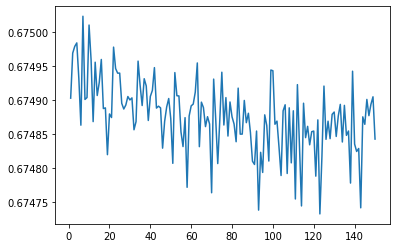

In [52]:
plt.plot(history[0:,0], history[0:,1])

In [53]:
x = torch.from_numpy(x_train)
x = model.encoder(x.float())
mean = model.mean(x)
log_var = model.log_var(x)
latent = mean
eps = torch.randn(mean.shape)

# 潜在変数の計算 μ + σ・ε
z = mean + torch.exp(log_var/2) * eps

model.decoder(z)[:5]

tensor([[0.5534, 0.5634, 0.3887, 0.4829, 0.4574, 0.4600, 0.5030, 0.4948, 0.4598,
         0.4902, 0.4370],
        [0.4970, 0.4870, 0.3444, 0.4534, 0.4421, 0.4471, 0.4977, 0.4941, 0.4626,
         0.4951, 0.4478],
        [0.5361, 0.4958, 0.3078, 0.3726, 0.3484, 0.3483, 0.3805, 0.3772, 0.3428,
         0.3717, 0.3343],
        [0.5188, 0.4902, 0.3328, 0.4341, 0.4187, 0.4231, 0.4694, 0.4634, 0.4339,
         0.4637, 0.4185],
        [0.4899, 0.4763, 0.3460, 0.4619, 0.4582, 0.4675, 0.5243, 0.5228, 0.4991,
         0.5323, 0.4865]], grad_fn=<SliceBackward0>)

In [54]:
x_train[:5]

array([[0.51648396, 0.59232433, 0.37852666, 0.47868892, 0.46644511,
        0.46623528, 0.5082539 , 0.49309692, 0.46997571, 0.48640781,
        0.44300283],
       [0.50534071, 0.47840122, 0.34177825, 0.43714027, 0.43200528,
        0.43861369, 0.48263425, 0.4855253 , 0.46467827, 0.50704858,
        0.44895448],
       [0.5510846 , 0.4788887 , 0.29687316, 0.36900485, 0.34465202,
        0.34379762, 0.37656471, 0.37495686, 0.34187969, 0.36804454,
        0.32879055],
       [0.52088634, 0.50050419, 0.32336993, 0.42348593, 0.41225263,
        0.41618647, 0.47424956, 0.46662061, 0.42559551, 0.4569089 ,
        0.41947705],
       [0.47382891, 0.47656157, 0.34417385, 0.46176403, 0.46318477,
        0.46798171, 0.52376054, 0.53535009, 0.50601305, 0.52325177,
        0.47221362]])

In [55]:
latent1 = z[:,0]
latent2 = z[:,1]

In [56]:
latent1 = latent1.detach().numpy()
latent2 = latent2.detach().numpy()

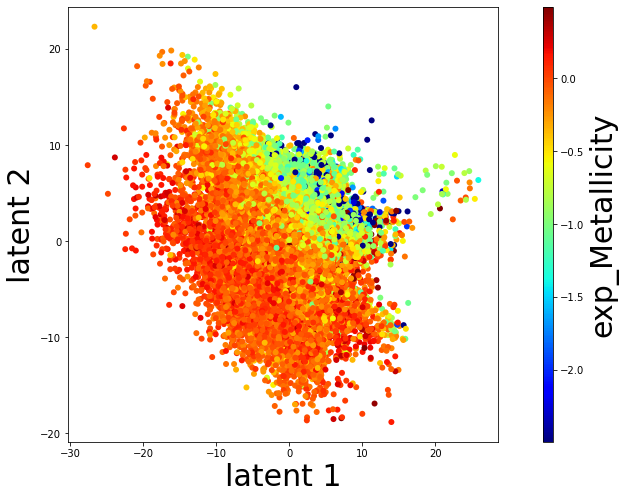

In [57]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['exp_met'], cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'exp_Metallicity').set_label('exp_Metallicity', fontsize=30)
plt.savefig('encoder_met.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

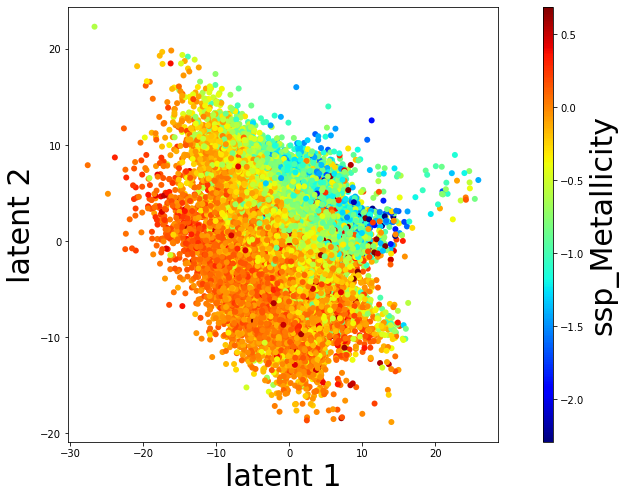

In [58]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_met'], cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'ssp_Metallicity').set_label('ssp_Metallicity', fontsize=30)
plt.savefig('encoder_ssp_met.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

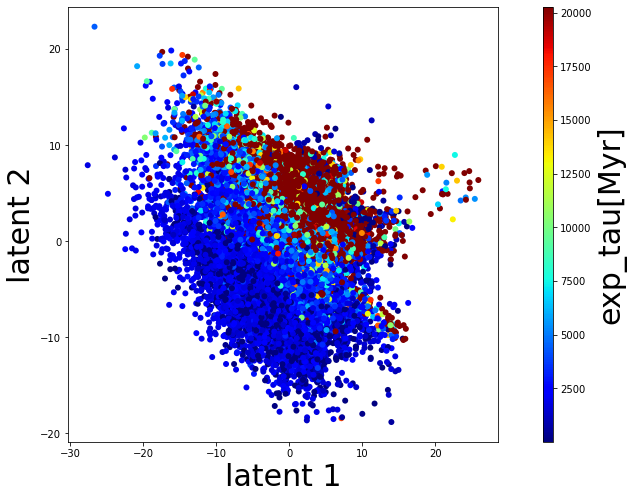

In [59]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['exp_tau'], cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical').set_label('exp_tau[Myr]', fontsize=30)
plt.savefig('encoder_tau_age.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

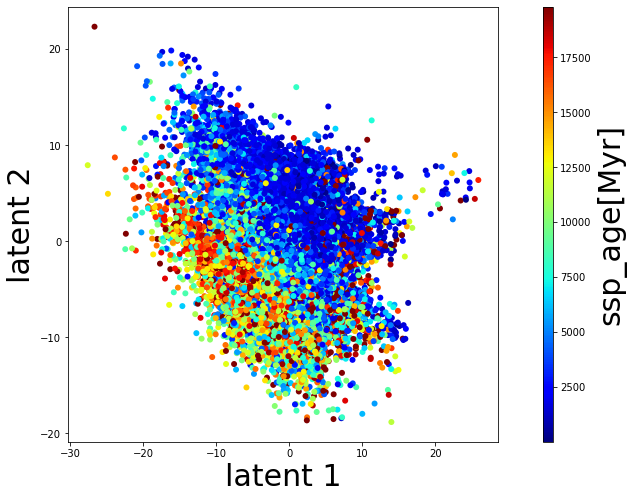

In [60]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_age'], cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical').set_label('ssp_age[Myr]', fontsize=30)
plt.savefig('encoder_age.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

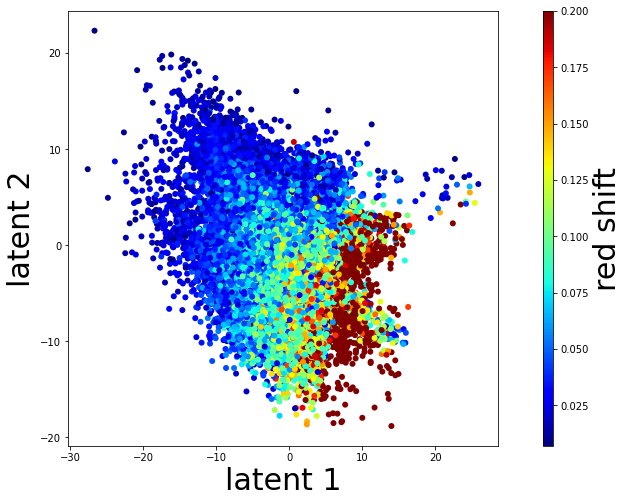

In [64]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['z'].values, cmap=plt.cm.jet, edgecolor='none', vmax=0.2)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'z').set_label('red shift', fontsize=30)
plt.savefig('encoder_z.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

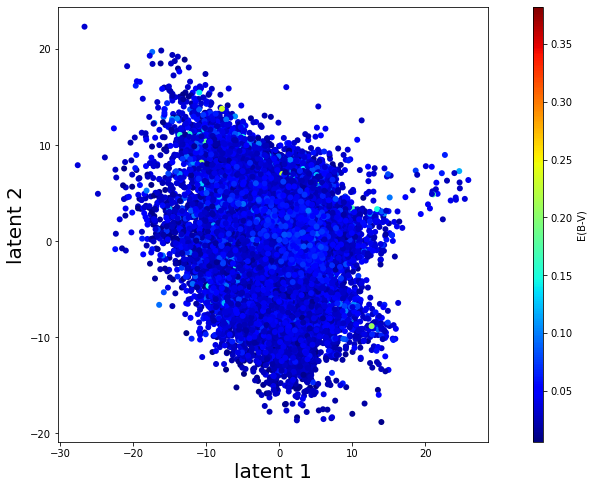

In [62]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['e_bv'].values, cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'E(B-V)')
plt.savefig('E(B-V).png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

In [ ]:
data['specclass'].value_counts()